In [1]:
import xarray as xr 
import dask

import warnings
warnings.filterwarnings('ignore')

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

import cartopy.feature as cf 
import cartopy.crs as ccrs 
import cartopy.mpl.ticker as cticker

from cartopy.util import add_cyclic_point
from matplotlib import animation
from tqdm import tqdm 

In [2]:
# Time batch selection
# batch = 4 complete
batch = 5

if batch==1:
    start, end = 1978, 1983
elif batch ==2:
    start, end = 1984, 1989    
elif batch ==3:
    start, end = 1990, 1992
elif batch==4:
    start, end = 1993, 1996
elif batch ==5:
    start, end = 1997, 2002
elif batch==6:
    start, end = 2006, 2007
elif batch ==7:
    start, end = 2014, 2019
elif batch==8:
    start, end = 2020, 2021  

In [3]:
# path = '/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/1979.nc'
path = '/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/ERA5 Sany/*.nc'
data = xr.open_mfdataset(path).sel(latitude=slice(25, 0), longitude=slice(78,100))
data = data.sel(time=slice(str(start), str(end)))
data

<xarray.Dataset>
Dimensions:    (longitude: 89, latitude: 101, level: 3, time: 52584)
Coordinates:
  * longitude  (longitude) float32 78.0 78.25 78.5 78.75 ... 99.5 99.75 100.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * level      (level) int32 150 500 850
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 101, 89), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 101, 89), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 101, 89), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 101, 89), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-05 11:53:24 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

# IBTRACS Cyclone Data

In [4]:
path='/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/ibtracs.NI.list.v04r00.xlsx - ibtracs.NI.list.v04r00.csv'
ib_data = pd.read_csv(path)
ib_data

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,,Year,,,,,,,degrees_north,degrees_east,...,second,kts,second,ft,nmile,nmile,nmile,nmile,kts,degrees
1,1842298N11080,1842,1,NI,BB,NOT_NAMED,1842-10-25 03:00:00,NR,10.9,80.3,...,,,,,,,,,9,266
2,1842298N11080,1842,1,NI,BB,NOT_NAMED,1842-10-25 06:00:00,NR,10.8709,79.8265,...,,,,,,,,,9,267
3,1842298N11080,1842,1,NI,BB,NOT_NAMED,1842-10-25 09:00:00,NR,10.8431,79.3524,...,,,,,,,,,9,267
4,1842298N11080,1842,1,NI,BB,NOT_NAMED,1842-10-25 12:00:00,NR,10.8188,78.8772,...,,,,,,,,,9,267
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60452,2022349N13068,2022,87,NI,AS,NOT_NAMED,12/16/22 18:00,NR,14.2,62.9,...,,,,,,,,,7,259
60453,2022349N13068,2022,87,NI,AS,NOT_NAMED,12/16/22 21:00,NR,14.115,62.5445,...,,,,,,,,,7,254
60454,2022349N13068,2022,87,NI,AS,NOT_NAMED,12/17/22 0:00,NR,14.0,62.2,...,,,,,,,,,7,252
60455,2022349N13068,2022,87,NI,AS,NOT_NAMED,12/17/22 3:00,NR,13.8945,61.8416,...,,,,,,,,,7,254


In [5]:
# print(ib_data.columns.values)

In [6]:
# ib_data['NATURE'].isin(['TS']).count()

In [7]:
# bb_data = ib_data[(ib_data['SUBBASIN'] == 'BB') & (ib_data['SEASON'] >= 1978) & (ib_data['NATURE'].isin(['TS', 'MX']))]
bb_data = ib_data[(ib_data['SUBBASIN'] == 'BB') & (ib_data['NATURE'].isin(['TS'])) & (ib_data['SEASON'].isin(range(start, end+1)))] #Notice
bb_data = bb_data.reset_index(drop=True)
# bb_data['NUMBER'] = bb_data.groupby('NUMBER').ngroup() + 1
bb_data['NUMBER'] = pd.factorize(bb_data['SID'])[0] + 1
bb_data

,SID,SEASON,NUMBER,BASIN,SUBBASIN,NAME,ISO_TIME,NATURE,LAT,LON,...,BOM_GUST_PER,REUNION_GUST,REUNION_GUST_PER,USA_SEAHGT,USA_SEARAD_NE,USA_SEARAD_SE,USA_SEARAD_SW,USA_SEARAD_NW,STORM_SPEED,STORM_DIR
0,1997298N06140,1997,1,NI,BB,LINDA,11/3/97 21:00,TS,12.1131,99.393,...,,,,,,,,,13,295
1,1997298N06140,1997,1,NI,BB,LINDA,11/4/97 0:00,TS,12.3667,98.7667,...,,,,,,,,,13,292
2,2000289N15089,2000,2,NI,BB,NOT_NAMED,10/14/00 18:00,TS,14.7,89.0,...,,,,,,,,,6,260
3,2000289N15089,2000,2,NI,BB,NOT_NAMED,10/14/00 21:00,TS,14.65,88.7125,...,,,,,,,,,6,257
4,2000289N15089,2000,2,NI,BB,NOT_NAMED,10/15/00 0:00,TS,14.575,88.425,...,,,,,,,,,5,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,2002355N02079,2002,11,NI,BB,NOT_NAMED,12/25/02 6:00,TS,7.3,85.05,...,,,,,,,,,13,72
287,2002355N02079,2002,11,NI,BB,NOT_NAMED,12/25/02 9:00,TS,7.57715,85.6688,...,,,,,,,,,11,63
288,2002355N02079,2002,11,NI,BB,NOT_NAMED,12/25/02 12:00,TS,7.8,86.06,...,,,,,,,,,7,60
289,2002355N02079,2002,11,NI,BB,NOT_NAMED,12/25/02 15:00,TS,7.91171,86.26,...,,,,,,,,,8,58


In [8]:
bb_data.SID.unique()

array(['1997298N06140', '2000289N15089', '2000299N13093', '2000331N09092',
       '2000358N08086', '2001313N12084', '2001361N01106', '2002129N08096',
       '2002314N12083', '2002327N10089', '2002355N02079'], dtype=object)

In [9]:
cyclone_data = bb_data[['NUMBER','ISO_TIME', 'LAT', 'LON']]
cyclone_data['ISO_TIME'] = pd.to_datetime(cyclone_data['ISO_TIME']) # without this the timestamp is in different type
cyclone_data

,NUMBER,ISO_TIME,LAT,LON
0,1,1997-11-03 21:00:00,12.1131,99.393
1,1,1997-11-04 00:00:00,12.3667,98.7667
2,2,2000-10-14 18:00:00,14.7,89.0
3,2,2000-10-14 21:00:00,14.65,88.7125
4,2,2000-10-15 00:00:00,14.575,88.425
...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05
287,11,2002-12-25 09:00:00,7.57715,85.6688
288,11,2002-12-25 12:00:00,7.8,86.06
289,11,2002-12-25 15:00:00,7.91171,86.26


In [10]:
cyclone_data.NUMBER.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

# Adding EYE Data

In [11]:
# data

In [12]:
# cyclone_data[:1]

In [13]:
# np.where(data.time==cyclone_data['ISO_TIME'][10])[0][0]

In [14]:
# NOT ENOUGH DATA 
# np.where(data.time==cyclone_data['ISO_TIME'][65])[0][0]
# print("CHECK ERROR")
# cyclone_data['ISO_TIME'][516]

In [15]:
# Remove this line when all the data is available
# cyclone_data=cyclone_data[:64]

In [16]:
# Eye data of Relative Humidity, Specific Humidity, Temperature*
r_eye = []
q_eye = []


for i in range(len(cyclone_data['LAT'])):
    lat_of_interest = cyclone_data['LAT'][i]
    lon_of_interest = cyclone_data['LON'][i]
    time_index = np.where(data.time==cyclone_data['ISO_TIME'][i])[0][0]
    
    # select the indices of the nearest latitude and longitude values in the 'data' dataset
    lat_idx = np.argmin(np.abs(data['latitude'].values - lat_of_interest))
    lon_idx = np.argmin(np.abs(data['longitude'].values - lon_of_interest))

    # extract the vvalues at the selected latitude and longitude position and 850 hPa
    r_value = data['r'][time_index, 2, lat_idx, lon_idx].values
    q_value = data['q'][time_index, 2, lat_idx, lon_idx].values

    
    r_eye.append((float(r_value)))
    q_eye.append((float(q_value)))


#adding data into the dataframe
cyclone_data['r_eye'] = r_eye
cyclone_data['q_eye'] = q_eye


#print
cyclone_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830
...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048


In [17]:
# debugging 
#ignore
# np.where(data.time==cyclone_data['ISO_TIME'][1837])[0][0]
# data.time[289090]
# cyclone_data['ISO_TIME'][1839]

In [18]:
# len(q_eye)

# Adding u and v at the eye

In [19]:
# cyclone_data

In [20]:
# data.level

In [21]:
# Eye data of u and v 

u_eye_150 = []
u_eye_500 = []
u_eye_850 = []

v_eye_150 = []
v_eye_500 = []
v_eye_850 = []

for l in range(3):
    for i in range(len(cyclone_data['LAT'])):
        lat_of_interest = cyclone_data['LAT'][i]
        lon_of_interest = cyclone_data['LON'][i]
        time_index = np.where(data.time==cyclone_data['ISO_TIME'][i])[0][0]

        # select the indices of the nearest latitude and longitude values in the 'data' dataset
        lat_idx = np.argmin(np.abs(data['latitude'].values - lat_of_interest))
        lon_idx = np.argmin(np.abs(data['longitude'].values - lon_of_interest))

        # extract the vvalues at the selected latitude and longitude position and 850 hPa
        u_value = data['u'][time_index, l, lat_idx, lon_idx].values
        v_value = data['v'][time_index, l, lat_idx, lon_idx].values
        
        if l == 0: #150 hpa
            u_eye_150.append((float(u_value)))
            v_eye_150.append((float(v_value)))
            
        if l == 1: #500 hpa
            u_eye_500.append((float(u_value)))
            v_eye_500.append((float(v_value)))
            
        if l == 2: #500 hpa
            u_eye_850.append((float(u_value)))
            v_eye_850.append((float(v_value)))

            
#adding data into the dataframe
cyclone_data['u_eye_150'] = u_eye_150
cyclone_data['u_eye_500'] = u_eye_500
cyclone_data['u_eye_850'] = u_eye_850

cyclone_data['v_eye_150'] = v_eye_150
cyclone_data['v_eye_500'] = v_eye_500
cyclone_data['v_eye_850'] = v_eye_850


print
cyclone_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye,u_eye_150,u_eye_500,u_eye_850,v_eye_150,v_eye_500,v_eye_850
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767,-12.143419,-8.395214,-19.228155,2.494177,-1.163599,-20.844780
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977,-9.136229,0.471489,-16.460129,3.124731,-1.441494,-17.277283
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839,-5.944192,-11.290606,-7.431825,-4.462907,2.387135,-5.947889
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741,-3.918521,-12.974575,-9.119570,-1.144506,2.068375,-6.518359
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830,-5.676117,-12.672518,-4.150727,-5.343344,7.618096,-1.572084
...,...,...,...,...,...,...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817,2.428284,-3.940223,1.969768,6.725255,-10.736389,-12.602467
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572,-1.907139,-5.358698,-2.568574,7.969306,-10.691472,-10.871139
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074,-7.042528,-6.660106,-3.109038,12.394266,-11.049443,-10.480501
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048,-5.060174,-6.088423,-2.297366,14.023511,-11.649692,-8.189757


# adding sst data

In [22]:
path = '/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/NEW_SST/ERA5*'
sst_data = xr.open_mfdataset(path)
sst_data = sst_data.sel(time=slice(str(start), str(end)))
sst_data

<xarray.Dataset>
Dimensions:    (longitude: 93, latitude: 101, time: 52584)
Coordinates:
  * longitude  (longitude) float32 78.0 78.25 78.5 78.75 ... 100.5 100.8 101.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(52584, 101, 93), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-24 14:26:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [23]:
sst_eye = []

for i in range(len(cyclone_data['LAT'])):
    lat_of_interest = cyclone_data['LAT'][i]
    lon_of_interest = cyclone_data['LON'][i]
    time_index = np.where(data.time==cyclone_data['ISO_TIME'][i])[0][0]
    
    # select the indices of the nearest latitude and longitude values in the 'data' dataset
    lat_idx = np.argmin(np.abs(data['latitude'].values - lat_of_interest))
    lon_idx = np.argmin(np.abs(data['longitude'].values - lon_of_interest))

    # extract the values at the selected latitude and longitude position and no level
    sst_value = sst_data['sst'][time_index, lat_idx, lon_idx].values
    
    sst_eye.append((float(sst_value)))

#adding data into the dataframe
cyclone_data['sst_eye'] = sst_eye

#print
cyclone_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye,u_eye_150,u_eye_500,u_eye_850,v_eye_150,v_eye_500,v_eye_850,sst_eye
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767,-12.143419,-8.395214,-19.228155,2.494177,-1.163599,-20.844780,NaN
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977,-9.136229,0.471489,-16.460129,3.124731,-1.441494,-17.277283,NaN
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839,-5.944192,-11.290606,-7.431825,-4.462907,2.387135,-5.947889,302.080597
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741,-3.918521,-12.974575,-9.119570,-1.144506,2.068375,-6.518359,302.046478
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830,-5.676117,-12.672518,-4.150727,-5.343344,7.618096,-1.572084,301.780701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817,2.428284,-3.940223,1.969768,6.725255,-10.736389,-12.602467,301.631378
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572,-1.907139,-5.358698,-2.568574,7.969306,-10.691472,-10.871139,301.808960
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074,-7.042528,-6.660106,-3.109038,12.394266,-11.049443,-10.480501,301.759277
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048,-5.060174,-6.088423,-2.297366,14.023511,-11.649692,-8.189757,301.676208


# Add grid data 

In [24]:
# np.arange(79, 101, 3)

In [25]:
# import dask

# with dask.config.set(**{'array.slicing.split_large_chunks': True}):

In [26]:
# Extract variable to interpolate
r = data['r']
q = data['q']
u = data['u']
v = data['v']

variables = [r,q,u,v]
variables_name = ['r','q', 'u','v']

# Define new grid to interpolate to
lon_new = np.arange(78, 101, 1)
lat_new = np.arange(0, 26, 1) 

# Create new dataset with new grid
data_new = xr.Dataset({'longitude': (['longitude'], lon_new),
                       'latitude': (['latitude'], lat_new)})

# Interpolate variable to new grid
# Add interpolated variable to new dataset
for i in range(len(variables)):
    new_var = variables[i].interp(longitude=lon_new, latitude=lat_new)
    data_new[variables_name[i]] = new_var

data_new

# Save new dataset as a netcdf file
# data_new.to_netcdf('your_new_file.nc')

<xarray.Dataset>
Dimensions:    (longitude: 23, latitude: 26, level: 3, time: 52584)
Coordinates:
  * longitude  (longitude) int64 78 79 80 81 82 83 84 ... 94 95 96 97 98 99 100
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24 25
  * level      (level) int32 150 500 850
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Data variables:
    r          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 26, 23), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 26, 23), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 26, 23), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 dask.array<chunksize=(8760, 3, 26, 23), meta=np.ndarray>

In [27]:
# lon=data_new.longitude.values
# lat=data_new.latitude.values

# total = 0
# for i in range(0, len(lon), 3):
#     for j in range(0, len(lat), 3):
#         #print(f"T-3 {lon[i]}_{lat[j]} relative_humidity is {data_new.r[1,2,j,i].values}")
#         total=total+1

# print(total)

# Rough calculation (ignore)

In [28]:
# u_x = data_new.u.compute()

In [29]:
# variables = [u,v]
# variables_name = ['u','v']
# data_new.variables[variables_name[0]][1, 0, 0, 0].values #array(89.02539062)

In [30]:
# u = data_new.u.compute()
# v = data_new.v.compute()

In [31]:
# variables = [u,v]
# for v in variables:
#     va = v[1, 0, 0, 0].values
#     print(va)

In [32]:
# u_x[1, 0, 0, 0].values

In [33]:
# # Not needed anymore
# # u and v wind data in 3 levels (150hPa, 500hPa, 850hPa)
# lon = data_new.longitude.values
# lat = data_new.latitude.values

# # u = data_new.u.compute()
# # v = data_new.v.compute()

# variables = [u,v]
# variables_name = ['u','v']

# data_dict = {}


# for l in tqdm(range(len(data_new.level.values))):
#     for var in variables:
#         for i in range(0, len(lon), 3):
#             for j in range(0, len(lat), 3):
#                 column_name = f"T-6_{lon[i]}_{lat[j]}_{var}_{data_new.level.values[l]}"
#                 # value = data_new.variables[variables_name[v]][1, l, j, i].values  #variables is default
#                 value = var[1, l, j, i].values
#                 if column_name not in data_dict:
#                     data_dict[column_name] = []
#                 data_dict[column_name].append(float(value))

# # Convert dictionary values to lists
# columns = list(data_dict.keys())
# values = list(data_dict.values())
# print(len(columns))

In [34]:
# np.where(data_new.time == cyclone_data['ISO_TIME'][0])
# for t in range(len(cyclone_data['ISO_TIME'])):
#     time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
#     print(data_new.time[time_index].values)

In [35]:
# data_new.variables['r']

In [36]:
# for t in tqdm(range(10)):
#     print(t)
    
# for var in variables:
    # print(str(var))

# Next

In [37]:
u = data_new.u.compute()

In [38]:
v = data_new.v.compute()

In [39]:
# Compute data
# u = data_new.u.compute()
# v = data_new.v.compute()
# r = data_new.r.compute()
# q = data_new.q.compute()

In [40]:
# u and v wind data in 3 levels (150hPa, 500hPa, 850hPa)
lon = data_new.longitude.values
lat = data_new.latitude.values
# time = data_new.time.values

# u = data_new.u.compute()
# v = data_new.v.compute()

variables = [u,v]
variables_name = ['u','v']

data_dict = {}

# for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
time_list = []

# for t in tqdm(range(2)):
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time=cyclone_data['ISO_TIME'][t]
    time_list.append(str(time))
    # data_dict['ISO_TIME'] = []
    
    for level in range(len(data_new.level.values)):
        for var in range(len(variables)):
            for lt in range(0, len(lat), 3):
                for ln in range(0, len(lon), 3):
                    column_name = f"T-0_{lon[ln]}_{lat[lt]}_{variables_name[var]}_{data_new.level.values[level]}"
                    value = variables[var][time_index, level, lt, ln].values  
                    if column_name not in data_dict:
                        data_dict[column_name] = []
                    data_dict[column_name].append(float(value))

# data_dict['ISO_TIME'] = time_list

100%|█████████████████████████████████████████| 291/291 [00:30<00:00,  9.43it/s]


In [41]:
pd.DataFrame(data_dict)

,T-0_78_0_u_150,T-0_81_0_u_150,T-0_84_0_u_150,T-0_87_0_u_150,T-0_90_0_u_150,T-0_93_0_u_150,T-0_96_0_u_150,T-0_99_0_u_150,T-0_78_3_u_150,T-0_81_3_u_150,...,T-0_96_21_v_850,T-0_99_21_v_850,T-0_78_24_v_850,T-0_81_24_v_850,T-0_84_24_v_850,T-0_87_24_v_850,T-0_90_24_v_850,T-0_93_24_v_850,T-0_96_24_v_850,T-0_99_24_v_850
0,15.901472,16.628765,16.952225,17.522688,15.397659,11.284827,13.896025,14.346908,6.764241,10.151740,...,0.627907,0.917087,0.860662,-1.746192,-1.993052,-6.550814,-1.466886,2.189480,1.539178,-0.511886
1,15.977926,17.781456,17.587379,16.593479,14.272414,10.900598,13.053071,12.980537,7.221004,12.882520,...,-0.613451,-0.193082,-0.695268,-2.742100,-3.180808,-7.102373,-2.856361,1.891836,0.721009,-0.829279
2,-25.317389,-28.636244,-32.982094,-32.111794,-28.611704,-29.793501,-23.584337,-23.433308,-27.360052,-26.387804,...,2.028805,2.011218,-3.770428,-4.723411,-9.092620,-2.061215,-0.273961,1.692458,3.414861,-0.293746
3,-27.660223,-29.278116,-32.498802,-30.567522,-26.236776,-30.527876,-24.705725,-22.885828,-26.899416,-27.377043,...,2.792730,0.466881,-3.861659,-5.362029,-9.641107,-1.513827,-0.973035,-0.291548,2.325582,-0.379482
4,-24.016655,-27.207136,-30.318327,-22.916035,-27.656446,-28.539965,-28.813704,-28.139738,-23.042521,-24.296059,...,0.798831,0.860385,-4.687138,-5.491732,-8.725496,-0.697142,0.232757,0.174501,1.074723,-1.091745
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,-22.587223,-25.127605,-17.840111,-11.268687,-4.917741,-6.059155,-7.481533,-8.341984,-17.354279,-18.501549,...,6.244784,4.680872,-1.618332,-2.264858,-1.298472,1.740881,-4.374574,1.467298,2.237685,1.596603
287,-24.912979,-26.023174,-19.340534,-9.225848,-1.950064,-7.118622,-10.271657,-11.791593,-25.443687,-21.705311,...,4.354206,4.947649,-0.215030,-2.436357,-1.879664,-0.262669,-3.590576,0.803078,0.656078,0.318524
288,-25.067120,-24.930538,-14.687078,-13.188605,-6.498161,-7.719572,-8.622947,-10.199466,-21.434105,-18.105465,...,2.620156,3.273487,0.023163,-1.881026,-1.859248,-0.338891,-2.707217,1.744964,-1.241305,0.473690
289,-25.962692,-18.489841,-16.909420,-10.057033,-9.598516,-8.232720,-10.964311,-13.750531,-23.674007,-22.253582,...,3.036654,3.481737,1.076660,-2.481274,-1.501277,-1.015361,-1.746276,0.966411,-1.743554,0.092580


In [42]:
cyclone_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye,u_eye_150,u_eye_500,u_eye_850,v_eye_150,v_eye_500,v_eye_850,sst_eye
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767,-12.143419,-8.395214,-19.228155,2.494177,-1.163599,-20.844780,NaN
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977,-9.136229,0.471489,-16.460129,3.124731,-1.441494,-17.277283,NaN
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839,-5.944192,-11.290606,-7.431825,-4.462907,2.387135,-5.947889,302.080597
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741,-3.918521,-12.974575,-9.119570,-1.144506,2.068375,-6.518359,302.046478
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830,-5.676117,-12.672518,-4.150727,-5.343344,7.618096,-1.572084,301.780701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817,2.428284,-3.940223,1.969768,6.725255,-10.736389,-12.602467,301.631378
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572,-1.907139,-5.358698,-2.568574,7.969306,-10.691472,-10.871139,301.808960
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074,-7.042528,-6.660106,-3.109038,12.394266,-11.049443,-10.480501,301.759277
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048,-5.060174,-6.088423,-2.297366,14.023511,-11.649692,-8.189757,301.676208


In [43]:
r = data_new.r.compute()
q = data_new.q.compute()

In [44]:
# relative and specific humidity data in 1 levels (850hPa) different time
variables = [r,q]
variables_name = ['r','q']

# data_dict = {}

l = 2 #850hPa

for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    for var in range(len(variables)):
        for i in range(0, len(lon), 3):
            for j in range(0, len(lat), 3):
                column_name = f"T-0_{lon[i]}_{lat[j]}_{variables_name[var]}_850"
                # value = data_new.variables[variables_name[v]][1, l, j, i].values  #variables is default
                value = variables[var][time_index, l, j, i].values 
                if column_name not in data_dict:
                    data_dict[column_name] = []
                data_dict[column_name].append(float(value))

# Convert dictionary values to lists
columns = list(data_dict.keys())
values = list(data_dict.values())
print(len(columns))

100%|█████████████████████████████████████████| 291/291 [00:09<00:00, 31.06it/s]

576


# T-n grid data add

In [45]:
# # Testing 
# # Ignore
# for t in tqdm(range(len(cyclone_data['ISO_TIME'])-228)):
#     print(cyclone_data['ISO_TIME'][t])
    
#     time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
#     print(time_index)
#     print('12 hours before ',data_new.time[time_index-12].values)
#     print('-------------')

In [46]:
# u and v wind data in 3 levels (150hPa, 500hPa, 850hPa)
variables = [u,v]
variables_name = ['u','v']

T_6_data_dict = {}
T_12_data_dict = {}

# For 6 hours before
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 6
    for level in range(len(data_new.level.values)):
        for var in range(len(variables)):
            for lt in range(0, len(lat), 3):
                for ln in range(0, len(lon), 3):
                    column_name = f"T-6_{lon[ln]}_{lat[lt]}_{variables_name[var]}_{data_new.level.values[level]}"
                    value = variables[var][time_index, level, lt, ln].values  
                    if column_name not in T_6_data_dict:
                        T_6_data_dict[column_name] = []
                    T_6_data_dict[column_name].append(float(value))

# For 12 hours before
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 12
    for level in range(len(data_new.level.values)):
        for var in range(len(variables)):
            for lt in range(0, len(lat), 3):
                for ln in range(0, len(lon), 3):
                    column_name = f"T-6_{lon[ln]}_{lat[lt]}_{variables_name[var]}_{data_new.level.values[level]}"
                    value = variables[var][time_index, level, lt, ln].values  
                    if column_name not in T_12_data_dict:
                        T_12_data_dict[column_name] = []
                    T_12_data_dict[column_name].append(float(value))


100%|█████████████████████████████████████████| 291/291 [00:31<00:00,  9.38it/s]


In [47]:
# Working on three hours before data 
# relative and specific humidity data in 1 levels (850hPa) different time
variables = [r,q]
variables_name = ['r','q']

# For 6 hours before
l = 2 #850hPa
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index = np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 6 # 6 hour before 
    for var in range(len(variables)):
        for i in range(0, len(lon), 3):
            for j in range(0, len(lat), 3):
                column_name = f"T-6_{lon[i]}_{lat[j]}_{variables_name[var]}_850"
                value = variables[var][time_index, l, j, i].values 
                if column_name not in T_6_data_dict:
                    T_6_data_dict[column_name] = []
                T_6_data_dict[column_name].append(float(value))

            
# For 12 hours before
l = 2 #850hPa
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index = np.where(data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 12 #12 hour before 
    for var in range(len(variables)):
        for i in range(0, len(lon), 3):
            for j in range(0, len(lat), 3):
                column_name = f"T-12_{lon[i]}_{lat[j]}_{variables_name[var]}_850"
                value = variables[var][time_index, l, j, i].values 
                if column_name not in T_12_data_dict:
                    T_12_data_dict[column_name] = []
                T_12_data_dict[column_name].append(float(value))

100%|█████████████████████████████████████████| 291/291 [00:09<00:00, 31.22it/s]


In [48]:
# Update and create data frame
T_6_data_dict.update(T_12_data_dict)
T_n_data_dict = pd.DataFrame(T_6_data_dict)
data_dict.update(T_n_data_dict)
pd.DataFrame(data_dict)

,T-0_78_0_u_150,T-0_81_0_u_150,T-0_84_0_u_150,T-0_87_0_u_150,T-0_90_0_u_150,T-0_93_0_u_150,T-0_96_0_u_150,T-0_99_0_u_150,T-0_78_3_u_150,T-0_81_3_u_150,...,T-12_96_24_q_850,T-12_99_0_q_850,T-12_99_3_q_850,T-12_99_6_q_850,T-12_99_9_q_850,T-12_99_12_q_850,T-12_99_15_q_850,T-12_99_18_q_850,T-12_99_21_q_850,T-12_99_24_q_850
0,15.901472,16.628765,16.952225,17.522688,15.397659,11.284827,13.896025,14.346908,6.764241,10.151740,...,0.010812,0.008727,0.014305,0.012947,0.012112,0.012642,0.012013,0.010789,0.009697,0.010745
1,15.977926,17.781456,17.587379,16.593479,14.272414,10.900598,13.053071,12.980537,7.221004,12.882520,...,0.010134,0.010113,0.014537,0.013416,0.011836,0.013194,0.011847,0.010903,0.009749,0.011685
2,-25.317389,-28.636244,-32.982094,-32.111794,-28.611704,-29.793501,-23.584337,-23.433308,-27.360052,-26.387804,...,0.011921,0.012162,0.013207,0.011948,0.012955,0.013334,0.013869,0.013491,0.012621,0.014310
3,-27.660223,-29.278116,-32.498802,-30.567522,-26.236776,-30.527876,-24.705725,-22.885828,-26.899416,-27.377043,...,0.013093,0.012023,0.011860,0.011517,0.013236,0.013927,0.014153,0.013504,0.012571,0.015585
4,-24.016655,-27.207136,-30.318327,-22.916035,-27.656446,-28.539965,-28.813704,-28.139738,-23.042521,-24.296059,...,0.012114,0.011538,0.011298,0.011686,0.012298,0.013100,0.014523,0.013849,0.011964,0.015183
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,-22.587223,-25.127605,-17.840111,-11.268687,-4.917741,-6.059155,-7.481533,-8.341984,-17.354279,-18.501549,...,0.005974,0.011802,0.010995,0.010302,0.009652,0.011854,0.011656,0.010136,0.009458,0.007100
287,-24.912979,-26.023174,-19.340534,-9.225848,-1.950064,-7.118622,-10.271657,-11.791593,-25.443687,-21.705311,...,0.006374,0.011633,0.010638,0.010778,0.009321,0.011833,0.011471,0.010384,0.009657,0.007006
288,-25.067120,-24.930538,-14.687078,-13.188605,-6.498161,-7.719572,-8.622947,-10.199466,-21.434105,-18.105465,...,0.006393,0.011153,0.010891,0.008785,0.009609,0.011547,0.011753,0.011175,0.010322,0.007690
289,-25.962692,-18.489841,-16.909420,-10.057033,-9.598516,-8.232720,-10.964311,-13.750531,-23.674007,-22.253582,...,0.006446,0.010187,0.010217,0.008447,0.010906,0.011776,0.011664,0.011373,0.010502,0.008617


# ADD SST Grid data

In [49]:
path = '/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/NEW_SST/ERA5*'
sst_data = xr.open_mfdataset(path).sel(time=slice(str(start),str(end))) #Selected year
# sst_data = xr.open_mfdataset(path).sel(time='1992')
sst_data

<xarray.Dataset>
Dimensions:    (longitude: 93, latitude: 101, time: 52584)
Coordinates:
  * longitude  (longitude) float32 78.0 78.25 78.5 78.75 ... 100.5 100.8 101.0
  * latitude   (latitude) float32 25.0 24.75 24.5 24.25 ... 0.75 0.5 0.25 0.0
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(52584, 101, 93), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-24 14:26:26 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

In [50]:
# dealing with expver
#ignore DANGER
# ERA5_1978 = latest_sst.sel(expver=1).sel(time='1978').drop('expver')
# ERA5_1978.to_netcdf('/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/NEW_SST/ERA5 hourly new 1978.nc')

In [51]:
# Extract variable to interpolate
sst = sst_data['sst']

variables = [sst]
variables_name = ['sst']

# Define new grid to interpolate to
lon_new = np.arange(78, 101, 1)
lat_new = np.arange(0, 26, 1) 

# Create new dataset with new grid
sst_data_new = xr.Dataset({'longitude': (['longitude'], lon_new),
                       'latitude': (['latitude'], lat_new)})

# Interpolate variable to new grid
# Add interpolated variable to new dataset
for i in range(len(variables)):
    new_var = variables[i].interp(longitude=lon_new, latitude=lat_new)
    sst_data_new[variables_name[i]] = new_var

sst_data_new

<xarray.Dataset>
Dimensions:    (longitude: 23, latitude: 26, time: 52584)
Coordinates:
  * longitude  (longitude) int64 78 79 80 81 82 83 84 ... 94 95 96 97 98 99 100
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24 25
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Data variables:
    sst        (time, latitude, longitude) float32 dask.array<chunksize=(52584, 26, 23), meta=np.ndarray>

In [52]:
sst = sst_data_new.sst.compute()
sst

<xarray.DataArray 'sst' (time: 52584, latitude: 26, longitude: 23)>
array([[[300.87249756, 300.83743286, 300.71343994, ..., 302.18414307,
         302.13223267,          nan],
        [300.89199829, 300.68127441, 300.69296265, ...,          nan,
                  nan,          nan],
        [300.85592651, 300.84912109, 300.7192688 , ..., 302.73980713,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[300.87249756, 300.83743286, 300.71343994, ..., 302.18414307,
         302.13223267,          nan],
        [300.89199829, 300.68127441, 300.69296265, ...,          nan,
                  nan,          nan],
        [300.85592651, 300.84912109, 300.7192688 , ..., 302.73980713,
                  nan,          nan],
...
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[302.29910278, 302.20239258, 302.28741455, ..., 303.13400269,
         303.29818726,          nan],
        [302.19754028, 302.37731934, 302.4387207 , ...,          nan,
                  nan,          nan],
        [302.2689209 , 302.38220215, 302.34490967, ..., 303.28649902,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]]])
Coordinates:
  * longitude  (longitude) int64 78 79 80 81 82 83 84 ... 94 95 96 97 98 99 100
  * latitude   (latitude) int64 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24 25
  * time       (time) datetime64[ns] 1997-01-01 ... 2002-12-31T23:00:00
Attributes:
    units:      K
    long_name:  Sea surface temperature

In [53]:
# SST Grid data in T-0

sst_data_dict = {}

for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(sst_data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    for i in range(0, len(lon), 3):
        for j in range(0, len(lat), 3):
            column_name = f"T-0_{lon[i]}_{lat[j]}_sst"
            value = sst[time_index, j, i].values 
            if column_name not in sst_data_dict:
                sst_data_dict[column_name] = []
            sst_data_dict[column_name].append(float(value))

100%|█████████████████████████████████████████| 291/291 [00:04<00:00, 59.60it/s]


In [54]:
# SST Grid data in T-n

# For 6 hour before
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(sst_data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 6
    for i in range(0, len(lon), 3):
        for j in range(0, len(lat), 3):
            column_name = f"T-6_{lon[i]}_{lat[j]}_sst"
            value = sst[time_index, j, i].values 
            if column_name not in sst_data_dict:
                sst_data_dict[column_name] = []
            sst_data_dict[column_name].append(float(value))

# For 12 hour before
for t in tqdm(range(len(cyclone_data['ISO_TIME']))):
    time_index=np.where(sst_data_new.time == cyclone_data['ISO_TIME'][t])[0][0]
    time_index = time_index - 12
    for i in range(0, len(lon), 3):
        for j in range(0, len(lat), 3):
            column_name = f"T-12_{lon[i]}_{lat[j]}_sst"
            value = sst[time_index, j, i].values 
            if column_name not in sst_data_dict:
                sst_data_dict[column_name] = []
            sst_data_dict[column_name].append(float(value))

100%|█████████████████████████████████████████| 291/291 [00:04<00:00, 67.83it/s]


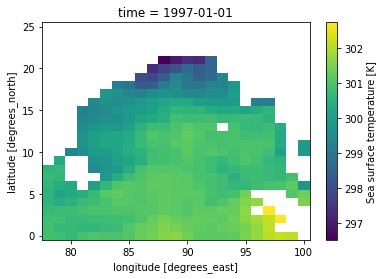

In [55]:
sst_data_new.sst[0,:,:].plot()

In [56]:
pd.DataFrame(sst_data_dict)

,T-0_78_0_sst,T-0_78_3_sst,T-0_78_6_sst,T-0_78_9_sst,T-0_78_12_sst,T-0_78_15_sst,T-0_78_18_sst,T-0_78_21_sst,T-0_78_24_sst,T-0_81_0_sst,...,T-12_96_24_sst,T-12_99_0_sst,T-12_99_3_sst,T-12_99_6_sst,T-12_99_9_sst,T-12_99_12_sst,T-12_99_15_sst,T-12_99_18_sst,T-12_99_21_sst,T-12_99_24_sst
0,300.623047,301.421844,301.951233,NaN,NaN,NaN,NaN,NaN,NaN,300.617188,...,NaN,299.005920,NaN,302.661133,NaN,NaN,NaN,NaN,NaN,NaN
1,300.737305,301.484467,301.833069,NaN,NaN,NaN,NaN,NaN,NaN,300.784088,...,NaN,299.005920,NaN,302.661133,NaN,NaN,NaN,NaN,NaN,NaN
2,301.740753,301.264252,301.082489,NaN,NaN,NaN,NaN,NaN,NaN,302.126404,...,NaN,302.164642,NaN,302.117615,NaN,NaN,NaN,NaN,NaN,NaN
3,301.740753,301.264252,301.082489,NaN,NaN,NaN,NaN,NaN,NaN,302.126404,...,NaN,302.164642,NaN,302.117615,NaN,NaN,NaN,NaN,NaN,NaN
4,301.717377,301.236725,301.095184,NaN,NaN,NaN,NaN,NaN,NaN,302.024811,...,NaN,302.164642,NaN,302.117615,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,302.291565,302.095215,301.418457,NaN,NaN,NaN,NaN,NaN,NaN,302.931061,...,NaN,302.703278,NaN,302.685730,NaN,NaN,NaN,NaN,NaN,NaN
287,302.291565,302.095215,301.418457,NaN,NaN,NaN,NaN,NaN,NaN,302.931061,...,NaN,302.703278,NaN,302.685730,NaN,NaN,NaN,NaN,NaN,NaN
288,302.291565,302.095215,301.418457,NaN,NaN,NaN,NaN,NaN,NaN,302.931061,...,NaN,302.629456,NaN,302.722290,NaN,NaN,NaN,NaN,NaN,NaN
289,302.291565,302.095215,301.418457,NaN,NaN,NaN,NaN,NaN,NaN,302.931061,...,NaN,302.629456,NaN,302.722290,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Update the original dictionary with sst grid data
data_dict.update(sst_data_dict)
data_dict_frame=pd.DataFrame(data_dict)

#removing nan columns 
data_dict_frame = data_dict_frame.dropna(axis=1, how='all')
data_dict_frame

,T-0_78_0_u_150,T-0_81_0_u_150,T-0_84_0_u_150,T-0_87_0_u_150,T-0_90_0_u_150,T-0_93_0_u_150,T-0_96_0_u_150,T-0_99_0_u_150,T-0_78_3_u_150,T-0_81_3_u_150,...,T-12_93_12_sst,T-12_93_15_sst,T-12_93_18_sst,T-12_96_0_sst,T-12_96_6_sst,T-12_96_9_sst,T-12_96_12_sst,T-12_96_15_sst,T-12_99_0_sst,T-12_99_6_sst
0,15.901472,16.628765,16.952225,17.522688,15.397659,11.284827,13.896025,14.346908,6.764241,10.151740,...,303.472626,303.687469,303.233368,298.300659,302.214813,302.707916,303.644592,303.893585,299.005920,302.661133
1,15.977926,17.781456,17.587379,16.593479,14.272414,10.900598,13.053071,12.980537,7.221004,12.882520,...,303.472626,303.687469,303.233368,298.300659,302.214813,302.707916,303.644592,303.893585,299.005920,302.661133
2,-25.317389,-28.636244,-32.982094,-32.111794,-28.611704,-29.793501,-23.584337,-23.433308,-27.360052,-26.387804,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
3,-27.660223,-29.278116,-32.498802,-30.567522,-26.236776,-30.527876,-24.705725,-22.885828,-26.899416,-27.377043,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
4,-24.016655,-27.207136,-30.318327,-22.916035,-27.656446,-28.539965,-28.813704,-28.139738,-23.042521,-24.296059,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,-22.587223,-25.127605,-17.840111,-11.268687,-4.917741,-6.059155,-7.481533,-8.341984,-17.354279,-18.501549,...,301.952454,300.657379,299.556000,302.774658,302.409485,302.688660,302.557831,301.510040,302.703278,302.685730
287,-24.912979,-26.023174,-19.340534,-9.225848,-1.950064,-7.118622,-10.271657,-11.791593,-25.443687,-21.705311,...,301.952454,300.657379,299.556000,302.774658,302.409485,302.688660,302.557831,301.510040,302.703278,302.685730
288,-25.067120,-24.930538,-14.687078,-13.188605,-6.498161,-7.719572,-8.622947,-10.199466,-21.434105,-18.105465,...,302.016998,300.706604,299.569885,302.738831,302.455505,302.839447,302.647003,301.482025,302.629456,302.722290
289,-25.962692,-18.489841,-16.909420,-10.057033,-9.598516,-8.232720,-10.964311,-13.750531,-23.674007,-22.253582,...,302.016998,300.706604,299.569885,302.738831,302.455505,302.839447,302.647003,301.482025,302.629456,302.722290


In [58]:
cyclone_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye,u_eye_150,u_eye_500,u_eye_850,v_eye_150,v_eye_500,v_eye_850,sst_eye
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767,-12.143419,-8.395214,-19.228155,2.494177,-1.163599,-20.844780,NaN
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977,-9.136229,0.471489,-16.460129,3.124731,-1.441494,-17.277283,NaN
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839,-5.944192,-11.290606,-7.431825,-4.462907,2.387135,-5.947889,302.080597
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741,-3.918521,-12.974575,-9.119570,-1.144506,2.068375,-6.518359,302.046478
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830,-5.676117,-12.672518,-4.150727,-5.343344,7.618096,-1.572084,301.780701
...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817,2.428284,-3.940223,1.969768,6.725255,-10.736389,-12.602467,301.631378
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572,-1.907139,-5.358698,-2.568574,7.969306,-10.691472,-10.871139,301.808960
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074,-7.042528,-6.660106,-3.109038,12.394266,-11.049443,-10.480501,301.759277
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048,-5.060174,-6.088423,-2.297366,14.023511,-11.649692,-8.189757,301.676208


In [59]:
# Merge cyclone_data and data_dict_frame
Preprocessed_data = pd.merge(cyclone_data, data_dict_frame, left_index=True, right_index=True)
Preprocessed_data

,NUMBER,ISO_TIME,LAT,LON,r_eye,q_eye,u_eye_150,u_eye_500,u_eye_850,v_eye_150,...,T-12_93_12_sst,T-12_93_15_sst,T-12_93_18_sst,T-12_96_0_sst,T-12_96_6_sst,T-12_96_9_sst,T-12_96_12_sst,T-12_96_15_sst,T-12_99_0_sst,T-12_99_6_sst
0,1,1997-11-03 21:00:00,12.1131,99.393,100.755943,0.014767,-12.143419,-8.395214,-19.228155,2.494177,...,303.472626,303.687469,303.233368,298.300659,302.214813,302.707916,303.644592,303.893585,299.005920,302.661133
1,1,1997-11-04 00:00:00,12.3667,98.7667,101.039383,0.012977,-9.136229,0.471489,-16.460129,3.124731,...,303.472626,303.687469,303.233368,298.300659,302.214813,302.707916,303.644592,303.893585,299.005920,302.661133
2,2,2000-10-14 18:00:00,14.7,89.0,96.681458,0.014839,-5.944192,-11.290606,-7.431825,-4.462907,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
3,2,2000-10-14 21:00:00,14.65,88.7125,92.783699,0.014741,-3.918521,-12.974575,-9.119570,-1.144506,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
4,2,2000-10-15 00:00:00,14.575,88.425,94.020714,0.014830,-5.676117,-12.672518,-4.150727,-5.343344,...,301.561951,302.036499,302.693787,302.062073,301.749512,301.311005,301.353882,301.994598,302.164642,302.117615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,11,2002-12-25 06:00:00,7.3,85.05,92.607353,0.013817,2.428284,-3.940223,1.969768,6.725255,...,301.952454,300.657379,299.556000,302.774658,302.409485,302.688660,302.557831,301.510040,302.703278,302.685730
287,11,2002-12-25 09:00:00,7.57715,85.6688,91.302223,0.013572,-1.907139,-5.358698,-2.568574,7.969306,...,301.952454,300.657379,299.556000,302.774658,302.409485,302.688660,302.557831,301.510040,302.703278,302.685730
288,11,2002-12-25 12:00:00,7.8,86.06,90.782120,0.013074,-7.042528,-6.660106,-3.109038,12.394266,...,302.016998,300.706604,299.569885,302.738831,302.455505,302.839447,302.647003,301.482025,302.629456,302.722290
289,11,2002-12-25 15:00:00,7.91171,86.26,87.829178,0.013048,-5.060174,-6.088423,-2.297366,14.023511,...,302.016998,300.706604,299.569885,302.738831,302.455505,302.839447,302.647003,301.482025,302.629456,302.722290


In [60]:
Preprocessed_data.to_csv('/media/sany/SSD/Document/Project_research/Climate/ML_CYCLONE/Data/Preprocessed/Preprocessed_data'+str(start)+'_'+str(end)+'.csv', index=False)

In [61]:
Preprocessed_data.NUMBER.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [62]:
# import pandas as pd

# # Convert 'ISO_TIME' column to datetime format
# cyclone_data['datetime'] = pd.to_datetime(cyclone_data['ISO_TIME'])

# # Define grid interval
# grid_interval = 3

# # Create empty DataFrame with desired columns
# df = pd.DataFrame(columns=['datetime', 'lon', 'lat', 'level', 'u', 'v'])

# # Loop over each time step and gridded data
# for i in range(len(cyclone_data)):
#     time = cyclone_data['datetime'][i]
#     lon = data_new.longitude.values[::grid_interval]
#     lat = data_new.latitude.values[::grid_interval]
#     level = data_new.level.values
#     u_values = data_new.variables['u'][1, :, ::grid_interval, ::grid_interval].values.flatten()
#     v_values = data_new.variables['v'][1, :, ::grid_interval, ::grid_interval].values.flatten()

#     # Create new DataFrame with gridded data
#     new_df = pd.DataFrame({
#         'datetime': time,
#         'lon': lon.repeat(len(lat)*len(level)),
#         'lat': np.tile(lat.repeat(len(level)), len(lon)),
#         'level': np.tile(level, len(lon)*len(lat)),
#         'u': u_values,
#         'v': v_values
#     })
    
#     # Append new DataFrame to the original DataFrame
#     df = df.append(new_df)

#WUITH TIME 

# lon = data_new.longitude.values
# lat = data_new.latitude.values
# time = data_new.time.values

# variables = [u,v]
# variables_name = ['u','v']

# data_dict = {}

# for t in range(len(time)):
#     for l in range(len(data_new.level.values)):
#         for v in range(len(variables)):
#             for i in range(0, len(lon), 3):
#                 for j in range(0, len(lat), 3):
#                     column_name = f"T-{t}_{lon[i]}_{lat[j]}_{variables_name[v]}_{data_new.level.values[l]}"
#                     value = data_new.variables[variables_name[v]][t, l, j, i].values
#                     if column_name not in data_dict:
#                         data_dict[column_name] = []
#                     data_dict[column_name].append(float(value))

# # Convert dictionary values to lists
# columns = list(data_dict.keys())
# values = list(data_dict.values())
# print(len(columns))

In [63]:
# pd.DataFrame(data_dict)

In [64]:
# columns